# HMK2 - How big is your world
## Estudiante: Andrés Calderón
### CCAS4501-1 Astroinformática

---

<br/>
Importamos las librerías necesarias para realizar la tarea:

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## P1) Analizar imagen FFI de planeta escogido en TESS

Para esta tarea elegimos el planeta $\textbf{TOI-163b}$, particularmente el sector 33:

In [2]:
target = 'TOI163b'

In [3]:
search_result = lk.search_targetpixelfile(target, mission='TESS')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 09,2019,SPOC,120,179317684,0.0
1,TESS Sector 10,2019,SPOC,120,179317684,0.0
2,TESS Sector 11,2019,SPOC,120,179317684,0.0
3,TESS Sector 12,2019,SPOC,120,179317684,0.0
4,TESS Sector 13,2019,SPOC,120,179317684,0.0
5,TESS Sector 33,2020,SPOC,20,179317684,0.0
6,TESS Sector 32,2020,SPOC,20,179317684,0.0
7,TESS Sector 31,2020,SPOC,20,179317684,0.0
8,TESS Sector 30,2020,SPOC,20,179317684,0.0


c:\Users\ninja\OneDrive\Escritorio\Academicos\DAS\Astroinformatica\venv\lib\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 33 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


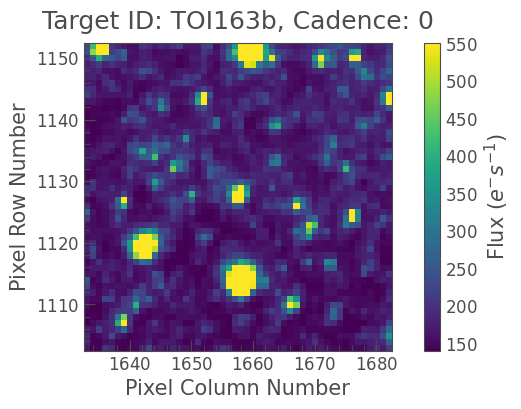

In [4]:
tpf = lk.search_tesscut(target=target).download(cutout_size=(50, 50))
tpf.plot();

c:\Users\ninja\OneDrive\Escritorio\Academicos\DAS\Astroinformatica\venv\lib\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 33 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


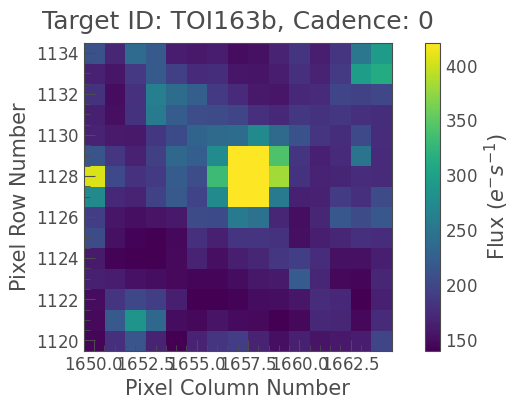

In [4]:
tpf = lk.search_tesscut(target=target).download(cutout_size=(15, 15))
tpf.plot();

In [101]:
tpf.animate()

### 1. Análisis preliminar:

Para establecer una valoración sobre la dispersión de la luz primero elegiremos un umbral adecuado para la máscara de la apertura, en este caso, no es tan relevante cual valor usar mientras no se utilice uno muy bajo, dado que el planeta que se está analizando, bajo este cutout de 15x15, no está rodeado de más estrellas que hagan ruido, por lo que se eligió un valor de 17 sigmas, el cual reconoce bastante bien este flujo.

Para

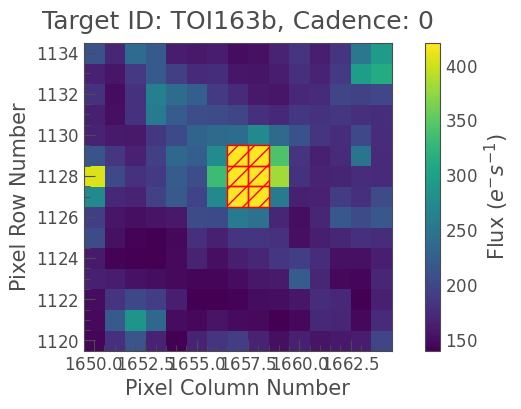

In [92]:
aper = tpf.create_threshold_mask(8)
tpf.plot(aperture_mask=aper);

Aquí se visualiza el background y el borde respectivamente:

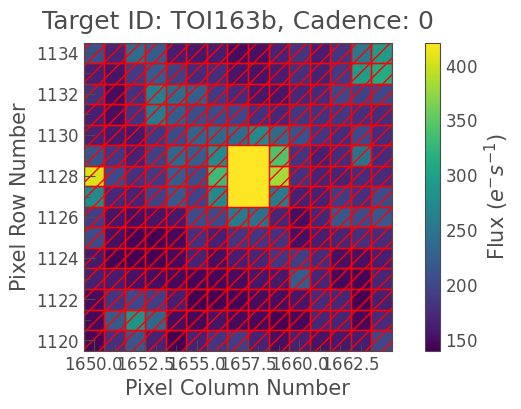

In [93]:
back = (tpf.create_threshold_mask(threshold=-100).astype(int) - aper.astype(int)).astype(bool)
tpf.plot(aperture_mask=back);

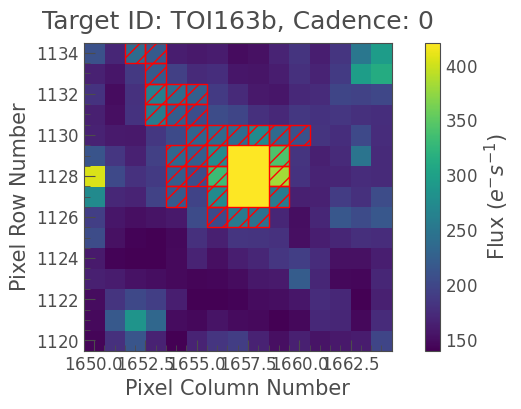

In [94]:
outer_region = (tpf.create_threshold_mask(threshold=1).astype(int) - aper.astype(int)).astype(bool)
tpf.plot(aperture_mask=outer_region);

Dadas las características del sector, al cambiar la máscara de la apertura esta apenas cambia los resultados puesto que la diferencia de píxeles seleccionados es muy pequeña.

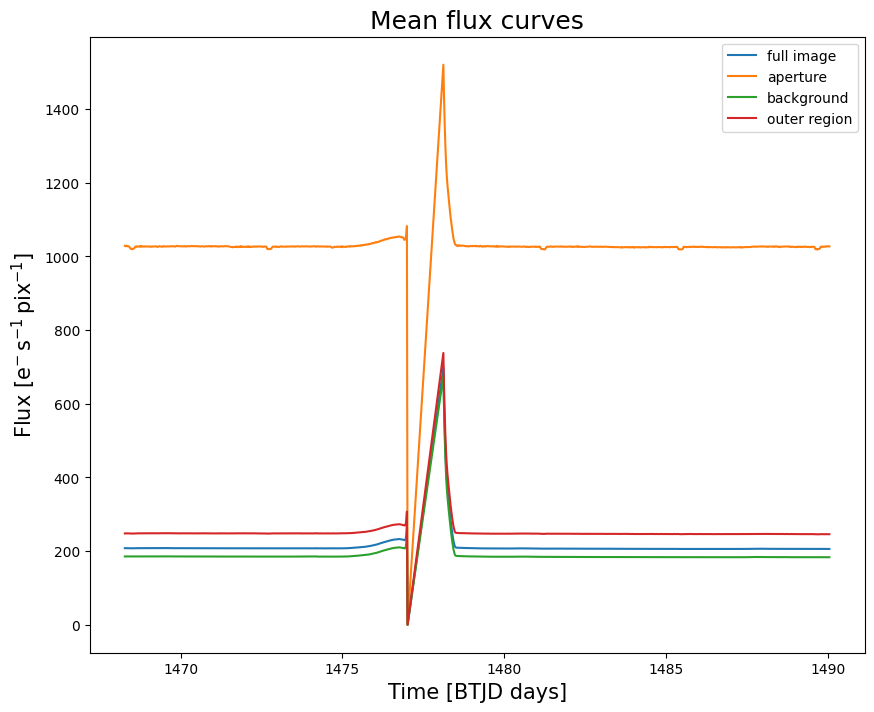

In [95]:
plt.figure(figsize=(10,8))
plt.title('Mean flux curves', fontsize=18)

# Visualize tpf flux [Full cut]:
plt.plot(tpf.time.value, np.mean(tpf.flux, axis=(1,2)), label='full image')

# Visualize tpf flux [aperture region]:
plt.plot(tpf.time.value, np.mean(tpf.flux[:, aper], axis=1), label='aperture')

# Visualize tpf flux [background]:
plt.plot(tpf.time.value, np.mean(tpf.flux[:, back], axis=1), label='background')

# Visualize tpf flux [outer region]:
plt.plot(tpf.time.value, np.mean(tpf.flux[:, outer_region], axis=1), label='outer region')

plt.ylabel('Flux [$\\mathrm{e^{-}\\,s^{-1}\\,pix^{-1}}$]', fontsize=15)
plt.xlabel('Time [BTJD days]', fontsize=15)
plt.legend()
plt.show();

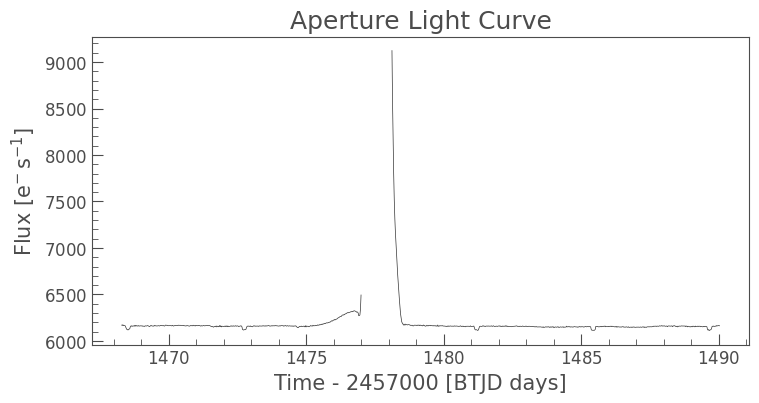

In [96]:
uncorrected_lc = tpf.to_lightcurve(aperture_mask=aper)
uncorrected_lc.plot()
plt.title('Aperture Light Curve', fontsize=18)
plt.show();

De estos gráficos ya se puede visualizar que la curva sin corregir posee unos seis gaps los cuales serán interferencias en la medida de la dispersión de la luz del planeta, lo cual no es un resultado ideal para analizar, junto con un salto en el gráfico producto de que en este intervalo de tiempo las mediciones se distorsionaron mucho y por ello el observatorio decidió borrar este flujo, con esto en consideración corregiremos la curva:

### 2. Corrección:

Para corregir la curva de luz del planeta utilizaremos el método de PLD, el cual consiste en primero calcular el ruido del modelo para cada instante de tiempo, luego se utiliza PCA para reducir las dimensiones de los vectores del modelo con el fin de limitar el conjunto y así capturar mejor el ruido. Y gracias a esta reducción es que se puede construir una matriz de diseño que contiene los flujos de píxeles fraccionarios. Finalmente para cada instante de tiempo se minimiza la diferencia al cuadrado entre el flujo original y el obtenido por este método.

c:\Users\ninja\OneDrive\Escritorio\Academicos\DAS\Astroinformatica\venv\lib\site-packages\astropy\utils\decorators.py:604: LightkurveDeprecationWarning: "aperture_mask" was deprecated in version 2.0 and will be removed in a future version. 
  return function(*args, **kwargs)
c:\Users\ninja\OneDrive\Escritorio\Academicos\DAS\Astroinformatica\venv\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)


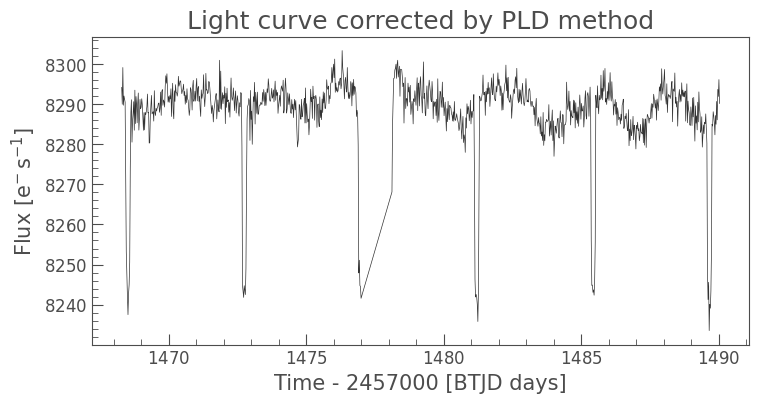

In [97]:
corrector = tpf.to_corrector('pld')
lc = corrector.correct(aperture_mask=aper)
lc.plot()
plt.title('Light curve corrected by PLD method', fontsize=18)
plt.show();

De este gráfico podemos ver que no hay tantas variaciones de la estrella lo que nos permite identificar seis gaps en esta con profundidades similares.

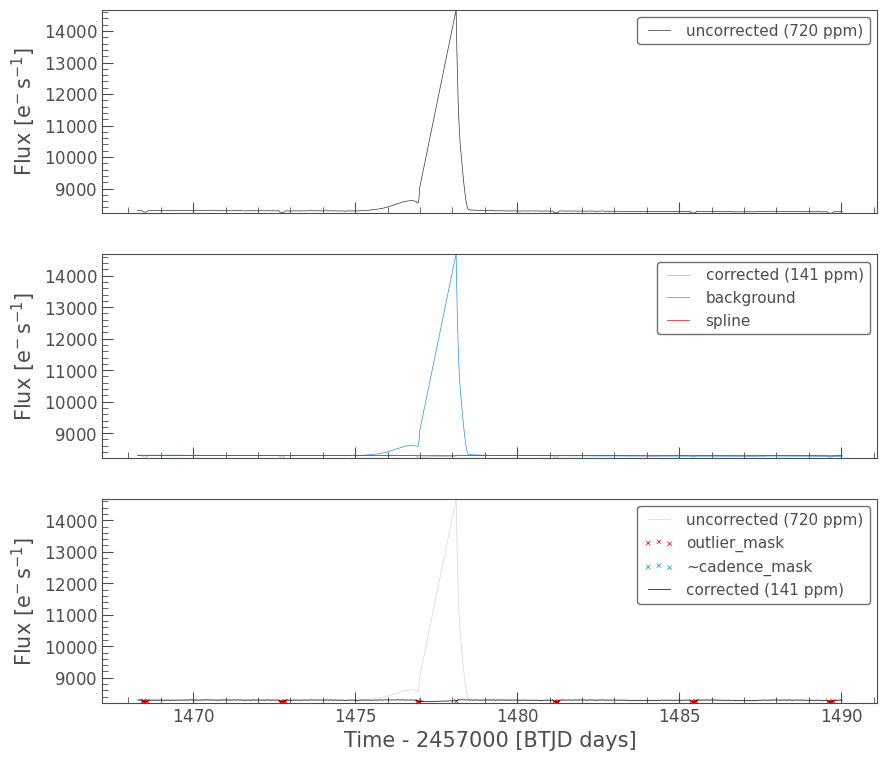

In [99]:
corrector.diagnose()
plt.show();

Del diagnóstico de la curva de luz corregida por PLD podemos primero visualizar que existen unas alteraciones de la curva sin corregir, lo cual indica que hubo un efecto de dispersión de luz por la Luna o la Tierra que interfirió con la medición del flujo, y además notamos los seis gaps mencionados anteriormente, los cuales denotan que hay tránsito en seis tiempos distintos marcados con los outlier masks presentes en el gráfico, indicando que este planeta pasó en frente de su estrella anfitriona en estas seis instancias, produciendo el efecto de atenuación de la luz.

### 3. Acercamiento alternativo:

Para este caso realizaremos una sustracción del promedio del flujo en el borde con el flujo de cada píxel en la apertura para eliminar el ruido, todo esto, para cada instante de tiempo disponible en la curva de luz:

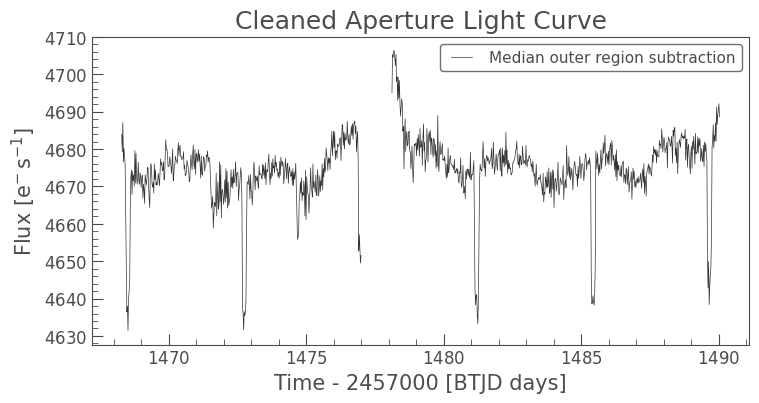

In [102]:
mean_subtracted_lc = uncorrected_lc - aper.sum()*np.mean(tpf.flux[:, outer_region], axis=1)

mean_subtracted_lc.plot(label='Median outer region subtraction')
plt.title('Cleaned Aperture Light Curve', fontsize=18)
plt.show();

A diferencia del primer método usado aqui la curva posee mucha más variación y no es tan clara la cantidad de gaps.

## P2) Producir la curva de luz

### 1. Ajustar la curva:

In [248]:
# Buscamos la curva de luz del planeta elegido
search_result_lc = lk.search_lightcurve('TOI163b', mission='TESS')

# Creamos un array de períodos de búsqueda
period = np.linspace(1, 15, 10000)

# Creamos un periodograma en base a este periodo
bls = lc.to_periodogram(method='bls', period=period)

# Obtenemos el periodo del planeta
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power
planet_b_deep = bls.depth_at_max_power

print('The period for planet b is:',planet_b_period);

The period for planet b is: 4.23012301230123 d


Creamos la función de flujo en el tiempo que queremos ajustar:

In [224]:
def flux_at_time(t, F, Rp, Rs, c, t_ingress, t_duration):
    arr = np.array([])
    t_med = t_ingress+t_duration/2.
    for i in t:
        r = Rs*2*(i-t_med)/t_duration
        lambda_val = np.sqrt(abs((Rs**2-r**2)/Rs**2))
        depth = (Rp / Rs)**2 * (1 + c * lambda_val)
        delta_F = F * depth
        t_egress = t_ingress + t_duration
        if i < t_ingress or i > t_egress:
            arr = np.append(arr, F)
        else:
            arr = np.append(arr, F - delta_F)
    return arr

Realizamos una estimación de los valores a los que queremos acercarnos cuando se realice el ajuste de la curva:

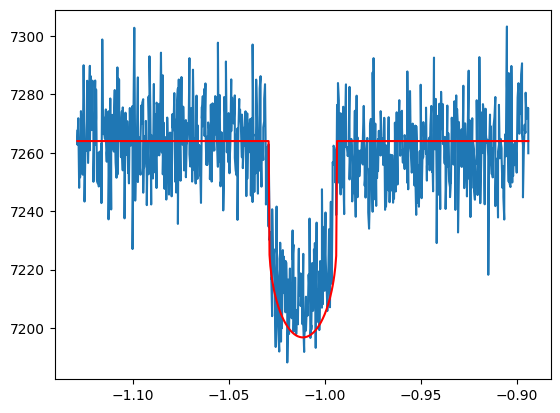

In [246]:
# Creamos un array con el intervalo de tiempo
lc_folded = lc.fold(period=planet_b_period, epoch_time=planet_b_t0)
time = lc_folded['time'].value

# Elegimos valores que se acerquen a lo esperado
F, Rp, Rs, c, t_ingress, t_duration = 7264, 0.068, 1, 1, -1.029, 0.0352
mod = flux_at_time(time, F, Rp, Rs, c, t_ingress, t_duration)

# Graficamos
fig = plt.figure()
filt = (time > t_ingress - .1) * (time < t_ingress + t_duration + .1)
plt.plot(time[filt], lc['flux'][filt])
plt.plot(time[filt], np.array(mod)[filt], 'r-');

Finalmente ajustamos el tránsito del modelo usando los valores previos como base y la función `curve_fit` de la librería `scipy`:

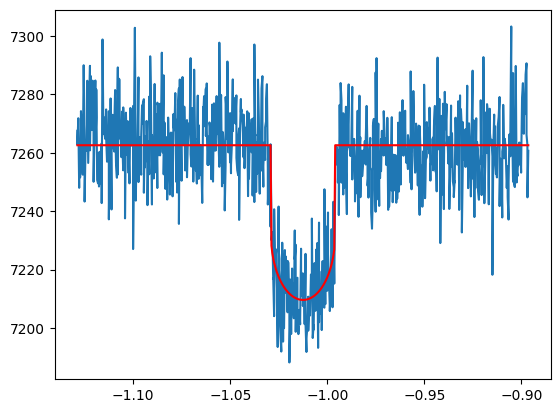

In [250]:
from scipy.optimize import curve_fit

params, covariance = curve_fit(flux_at_time, time[filt], lc['flux'][filt], p0=[F, Rp, Rs, c, t_ingress, t_duration])

F, Rp, Rs, c, t_ingress, t_duration = params

mod = flux_at_time(time, F, Rp, Rs, c, t_ingress, t_duration)

# Graficamos
fig = plt.figure()
filt = (time > t_ingress - .1) * (time < t_ingress + t_duration + .1)
plt.plot(time[filt], lc['flux'][filt])
plt.plot(time[filt], np.array(mod)[filt], 'r-');

### 2. Incertezas del ajuste:

In [251]:
param_errors = np.sqrt(np.diag(covariance))
param_errors

array([4.60592364e-01, 1.59528540e+03, 2.46805610e+04, 8.00720227e-01,
       2.20457086e-03, 4.73439807e-03])



Del resultado anterior obtuvimos las siguientes incertezas:

- Flujo de la estrella fuera del tránsito: 4.57741203e-01
- Radio del planeta: 1.47846577e+03
- Radio de la estrella: 2.58642011e+04
- Coeficiente lineal de oscurecimiento de borde: 5.29684890e-01
- Tiempo de ingreso: 7.07961254e-04
- Tiempo de duración: 5.28734361e-04

Se puede evidenciar que los radios del planeta y de la estrella poseen mayores incertezas, debido a las magnitudes con las que se trabajan en estas unidades de medida.